# Getting Started with pymash

This notebook introduces `pymash`, a Python implementation of Multivariate
Adaptive Shrinkage ([Urbut et al. 2019](https://doi.org/10.1038/s41588-018-0268-8)).

mash is a method for dealing with large numbers of tests across many conditions
(e.g., tissues, time points, treatments, or phenotypes). There are four steps
to a mash analysis:

1. **Read in the data** — provide matrices of effects and standard errors
2. **Set up covariance matrices** — specify patterns of effect sharing
3. **Fit the model** — estimate mixture proportions
4. **Extract results** — posterior means, significance, sharing

> **The Crucial Rule:** Step 3 (fitting) must be performed with *all* tests
> or a *large random subset*. Do not fit on only significant/strong tests,
> because mash needs to learn about the null signal to properly shrink estimates.

In [1]:
import numpy as np
import pymash as mash

## Simulate Data

`simple_sims()` creates a dataset with 5 conditions and four effect types:
null, independent, condition-1-specific, and shared (equal across conditions).
With `nsamp=500`, this produces 2000 total effects.

In [2]:
sim = mash.simple_sims(nsamp=500, ncond=5, err_sd=1.0, seed=1)
print(f"Bhat shape: {sim['Bhat'].shape}")
print(f"Shat shape: {sim['Shat'].shape}")

Bhat shape: (2000, 5)
Shat shape: (2000, 5)


## Step 1: Set Up the Data

To run mash you need a matrix of effects (`Bhat`) and a matrix of standard
errors (`Shat`), with J effects (rows) in R conditions (columns).

If you only have Z-scores, set `Bhat` to the Z-scores and `Shat` to a matrix of ones.

In [3]:
data = mash.mash_set_data(sim["Bhat"], sim["Shat"])
print(f"Effects: {data.n_effects}, Conditions: {data.n_conditions}")

Effects: 2000, Conditions: 5


## Step 2: Set Up Covariance Matrices

mash uses a mixture of multivariate normal distributions, each parameterized
by a covariance matrix, to model the patterns of effects across conditions.

Here we use **canonical** covariance matrices, which encode common sharing
patterns like identity (independent), singletons (condition-specific),
equal effects (fully shared), and simple heterogeneous.

In [4]:
U_c = mash.cov_canonical(data)
print(f"Canonical covariances: {list(U_c.keys())}")

Canonical covariances: ['identity', 'singleton_1', 'singleton_2', 'singleton_3', 'singleton_4', 'singleton_5', 'equal_effects', 'simple_het_1', 'simple_het_2', 'simple_het_3']


## Step 3: Fit the Model

The `mash()` function fits a mixture model:
$$B \sim \sum_k \sum_l \pi_{kl}\, N(0,\, \omega_l\, U_k)$$
where the $\omega_l$ are grid scaling factors and $U_k$ are the covariance
matrices.

**Remember the Crucial Rule!** Fit on all tests (or a large random subset).

In [5]:
result = mash.mash(data, Ulist=U_c)
print(f"Log-likelihood: {result.loglik:.2f}")

Log-likelihood: -16007.26


## Step 4: Extract Results

### Posterior Estimates

Extract posterior means, standard deviations, and local false sign rates (lfsr).
Each is a J × R matrix.

In [6]:
pm = mash.get_pm(result)
psd = mash.get_psd(result)
lfsr = mash.get_lfsr(result)

print("Posterior means (first 5 effects):")
print(pm[:5].round(3))
print("\nLocal false sign rates (first 5 effects):")
print(lfsr[:5].round(3))

Posterior means (first 5 effects):
[[-0.196 -0.031 -0.135 -0.093 -0.128]
 [ 0.508 -0.317  0.092 -0.011 -0.447]
 [ 0.383 -0.057 -0.026  0.023 -0.09 ]
 [-0.134 -0.014 -0.088 -0.002  0.1  ]
 [-0.225 -0.214 -0.059 -0.002  0.025]]

Local false sign rates (first 5 effects):
[[0.65  0.789 0.732 0.751 0.735]
 [0.445 0.562 0.682 0.715 0.523]
 [0.581 0.808 0.825 0.823 0.791]
 [0.714 0.83  0.789 0.833 0.794]
 [0.628 0.692 0.766 0.795 0.814]]


### Significant Results

`get_significant_results()` returns indices of effects with lfsr below the
threshold in at least one condition, sorted from most to least significant.

In [7]:
sig = mash.get_significant_results(result, thresh=0.05)
print(f"Number of significant effects (lfsr < 0.05): {len(sig)}")
print(f"Top 10 significant indices: {sig[:10]}")

# Significant in condition 1 only
sig_cond1 = mash.get_significant_results(result, conditions=[0])
print(f"Significant in condition 1: {len(sig_cond1)}")

Number of significant effects (lfsr < 0.05): 123
Top 10 significant indices: [1887 1938 1975 1946 1968 1867 1792 1647 1998 1969]
Significant in condition 1: 99


### Forest Plot (Meta-plot)

`mash_plot_meta()` shows the posterior mean ± CI for one effect across all conditions.

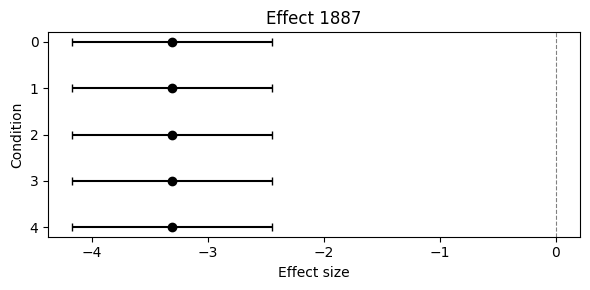

In [8]:
import matplotlib.pyplot as plt

# Plot the most significant effect
fig, ax = plt.subplots(figsize=(6, 3))
mash.mash_plot_meta(result, sig[0], ax=ax)
ax.set_title(f"Effect {sig[0]}")
plt.tight_layout()
plt.show()

### Pairwise Sharing

`get_pairwise_sharing()` computes, for each pair of conditions, the fraction
of significant effects that are the same sign and within a factor of each other.

In [9]:
sharing = mash.get_pairwise_sharing(result, factor=0.5)
print("Pairwise sharing (same sign, within factor 0.5):")
print(np.array2string(sharing, precision=2))

# Sign sharing only (factor=0)
sign_sharing = mash.get_pairwise_sharing(result, factor=0)
print("\nPairwise sharing (same sign only):")
print(np.array2string(sign_sharing, precision=2))

Pairwise sharing (same sign, within factor 0.5):
[[1.   0.84 0.87 0.84 0.86]
 [0.84 1.   0.95 0.92 0.91]
 [0.87 0.95 1.   0.97 0.95]
 [0.84 0.92 0.97 1.   0.93]
 [0.86 0.91 0.95 0.93 1.  ]]

Pairwise sharing (same sign only):
[[1.   0.94 0.93 0.94 0.96]
 [0.94 1.   0.98 0.96 0.96]
 [0.93 0.98 1.   0.98 0.97]
 [0.94 0.96 0.98 1.   0.95]
 [0.96 0.96 0.97 0.95 1.  ]]


### Mixture Proportions

`get_estimated_pi()` extracts the estimated weight on each type of covariance
matrix. This tells you which sharing patterns are most common in your data.

In [10]:
pi_cov = mash.get_estimated_pi(result, dimension="cov")

# The first entry is the null component (if usepointmass=True)
labels = ["null"] + list(U_c.keys())
for name, weight in zip(labels, pi_cov):
    if weight > 0.01:
        print(f"  {name}: {weight:.3f}")

  null: 0.385
  identity: 0.297
  singleton_1: 0.099
  equal_effects: 0.210


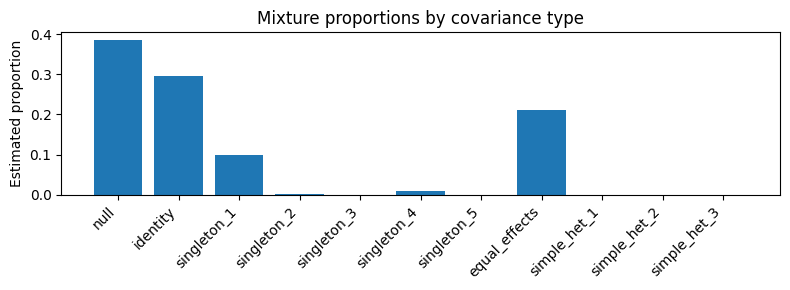

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(range(len(pi_cov)), pi_cov)
ax.set_xticks(range(len(pi_cov)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Estimated proportion")
ax.set_title("Mixture proportions by covariance type")
plt.tight_layout()
plt.show()

The large weight on "null" reflects that many effects are null. The non-null
weight is spread across identity, singleton_1, and equal_effects, matching
how the data were simulated.